# Recommender System Testing

The focus of this notebook is to test various code snippest, processing, subcomponents and integration of subcomponents for the recommender system

## Data Processing

External databases are initially used to test and train the recommender system so no actual pre-processing is required for that but when an online version is created and data is logged this will need to be processed and stored. For now the csv ratings file will be loaded and mappings will be created from user and movie ids to indexes. A sparse matrix will then be created to make indexing much easier, for this project double indexing will be done as it is more efficient than having a full sparse matrix.

In [1]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import optuna

train_ratio = 0.8
optuna_optimisation = False
# optuna_optimisation = True

external_data_path = "../data/external/"
image_path = "images/"

In [2]:
folder_name = external_data_path + "ml-latest-small"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []

test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < train_ratio:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 0.18152952194213867 seconds
Train Count: 80586
Test Count: 20250


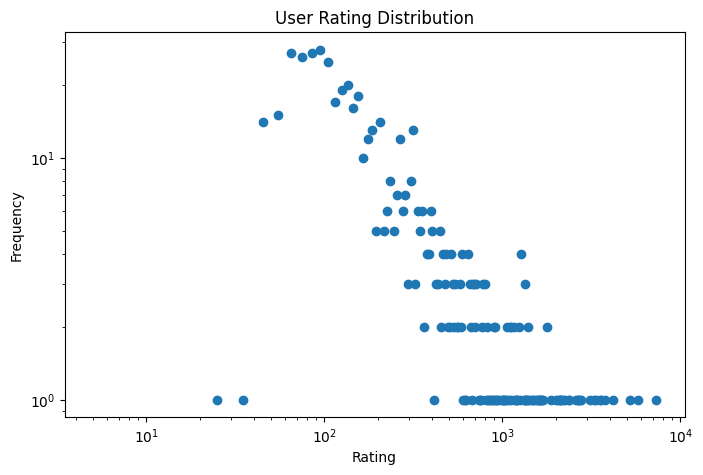

In [3]:
user_total_ratings = []

for row in user_ratings_train:
    user_sum = sum([rating for _, rating in row])
    user_total_ratings.append(user_sum)

all_user_ratings = [rating for rating in user_total_ratings]
user_rating_counts = Counter(all_user_ratings)
user_ratings = np.array(sorted(user_rating_counts.keys()))
user_frequencies = np.array([user_rating_counts[r] for r in user_ratings])

user_bin_edges = np.arange(0, max(user_total_ratings) + 10, 10)
user_frequencies, user_bins = np.histogram(user_total_ratings, bins=user_bin_edges)
user_bin_centers = 0.5 * (user_bins[1:] + user_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(user_bin_centers, user_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('User Rating Distribution')
plt.savefig(image_path + 'user_rating_distribution.svg')
plt.show()

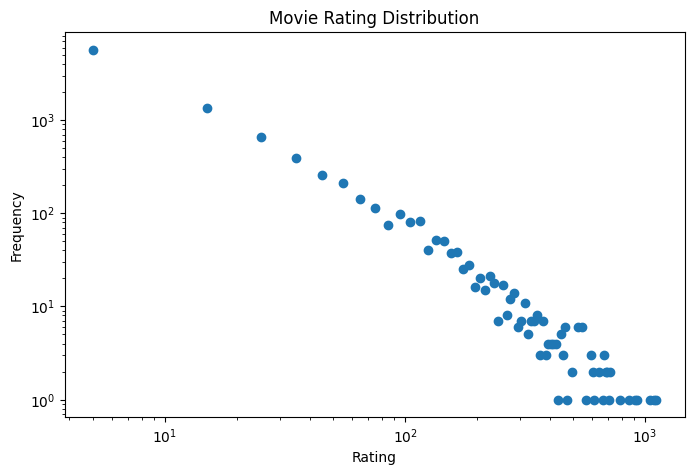

In [4]:
movie_total_ratings = []

for row in movie_ratings_train:
    movie_sum = sum([rating for _, rating in row])
    movie_total_ratings.append(movie_sum)

all_movie_ratings = [rating for rating in movie_total_ratings]
movie_rating_counts = Counter(all_movie_ratings)
movie_ratings = np.array(sorted(movie_rating_counts.keys()))
movie_frequencies = np.array([movie_rating_counts[r] for r in movie_ratings])

movie_bin_edges = np.arange(0, max(movie_total_ratings) + 10, 10)
movie_frequencies, movie_bins = np.histogram(movie_total_ratings, bins=movie_bin_edges)
movie_bin_centers = 0.5 * (movie_bins[1:] + movie_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(movie_bin_centers, movie_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating Distribution')
plt.savefig(image_path + 'movie_rating_distribution.svg')
plt.show()

## Bias Model 

In [5]:
# Hyperparameters
lam = 0.1
gamma = 0.1
num_epochs = 100

# Configure Biases
user_biases = np.zeros(len(user_ratings_train))
item_biases = np.zeros(len(movie_ratings_train))
training_loss = []
training_RMSE = []
testing_RMSE = []

# Estimate biases with loss function
for epoch in range(num_epochs):
    for u in range(len(user_ratings_train)):
        bias = 0
        counter = 0
        for movie_idx, rating in user_ratings_train[u]:
            bias += (rating - item_biases[movie_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        user_biases[u] = bias

    for m in range(len(movie_ratings_train)):
        bias = 0
        counter = 0
        for user_idx, rating in movie_ratings_train[m]:
            bias += (rating - user_biases[user_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        item_biases[m] = bias

    train_loss = 0
    count = 0
    train_error = 0
    for u, user_ratings in enumerate(user_ratings_train):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            train_error += (rating - pred) * (rating - pred)
            count += 1 
    train_rmse = np.sqrt(train_error / (count + 1e-10))
    train_loss = (lam * (train_error)) + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)))
    training_loss.append(train_loss)
    training_RMSE.append(train_rmse)

    test_loss = 0
    test_error = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_test):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            test_error += (rating - pred) * (rating - pred)
            count += 1
    test_rmse = np.sqrt(test_error / (count + 1e-10))
    testing_RMSE.append(test_rmse)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 1/100, Loss: 6229.6533, Train RMSE: 0.8055, Test RMSE: 0.8770
Epoch 2/100, Loss: 6038.4765, Train RMSE: 0.7918, Test RMSE: 0.8662
Epoch 3/100, Loss: 6011.0248, Train RMSE: 0.7907, Test RMSE: 0.8658
Epoch 4/100, Loss: 5994.4441, Train RMSE: 0.7905, Test RMSE: 0.8657
Epoch 5/100, Loss: 5980.9180, Train RMSE: 0.7905, Test RMSE: 0.8656
Epoch 6/100, Loss: 5969.5874, Train RMSE: 0.7904, Test RMSE: 0.8656
Epoch 7/100, Loss: 5960.0710, Train RMSE: 0.7904, Test RMSE: 0.8656
Epoch 8/100, Loss: 5952.0755, Train RMSE: 0.7905, Test RMSE: 0.8657
Epoch 9/100, Loss: 5945.3573, Train RMSE: 0.7905, Test RMSE: 0.8657
Epoch 10/100, Loss: 5939.7124, Train RMSE: 0.7905, Test RMSE: 0.8658
Epoch 11/100, Loss: 5934.9692, Train RMSE: 0.7906, Test RMSE: 0.8659
Epoch 12/100, Loss: 5930.9837, Train RMSE: 0.7906, Test RMSE: 0.8661
Epoch 13/100, Loss: 5927.6349, Train RMSE: 0.7906, Test RMSE: 0.8662
Epoch 14/100, Loss: 5924.8211, Train RMSE: 0.7907, Test RMSE: 0.8663
Epoch 15/100, Loss: 5922.4568, Train RMSE: 

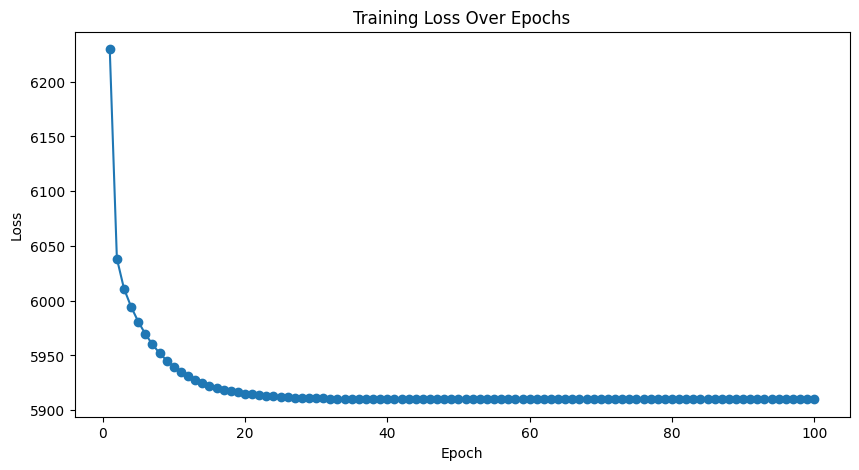

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'bias_trianing_loss.svg')
plt.show()

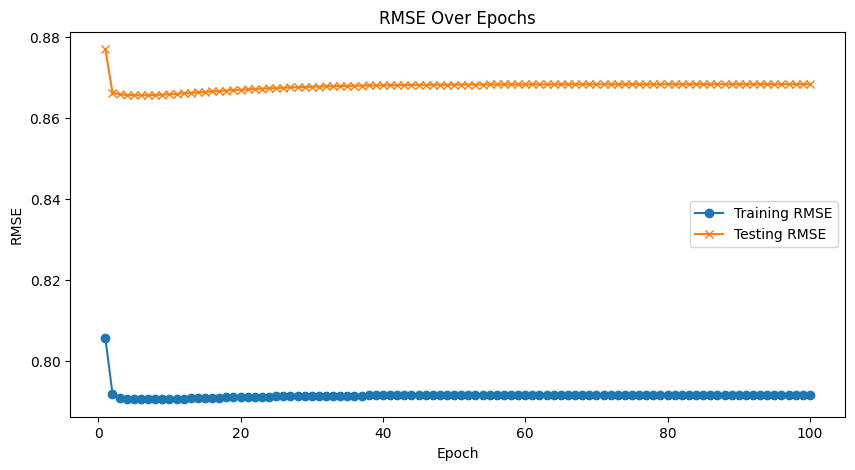

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'bias_rmse.svg')
plt.show()

## Full Model

#### First Version

In [8]:
def training_old(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            bias = 0
            counter = 0
            user = 0
            for movie_idx, rating in user_ratings_train[u]:
                bias += lam * (rating - ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            user_biases[u] = bias
            
            user_term = 0
            user_inverse_term = 0
            for movie_idx, rating in user_ratings_train[u]:
                user_inverse_term += lam * ((item_embeddings[movie_idx].T @ item_embeddings[movie_idx]) + (tau * np.eye(embeddings_dim)))
                user_term += lam * item_embeddings[movie_idx] * (rating - user_biases[u] - item_biases[movie_idx])
            user = np.linalg.solve(user_inverse_term, user_term)
            user_embeddings[u] = user

        for m in range(len(movie_ratings_train)):
            bias = 0
            counter = 0
            for user_idx, rating in movie_ratings_train[m]:
                bias += lam * (rating - ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            item_biases[m] = bias

            item_term = 0
            item_inverse_term = 0
            for user_idx, rating in movie_ratings_train[m]:
                item_inverse_term += lam * ((user_embeddings[user_idx].T @ user_embeddings[user_idx]) + (tau * np.eye(embeddings_dim)))
                item_term += lam * user_embeddings[user_idx] * (rating - user_biases[user_idx] - item_biases[m])
            item = np.linalg.solve(item_inverse_term, item_term)
            item_embeddings[m] = item

        train_loss = 0
        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings.T @ user_embeddings) + np.sum(item_embeddings.T @ item_embeddings)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

#### Optimised Version

In [9]:
def training_optimised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    tau_identity = tau * np.eye(embeddings_dim)

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            counter = 0
            ratings = np.zeros(len(user_ratings_train[u]))
            pred = np.zeros(len(user_ratings_train[u]))
            for movie_idx, rating in user_ratings_train[u]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            user_biases[u] = bias / ((lam * counter) + gamma)
            
            user_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            user_term = np.zeros(embeddings_dim)
            for movie_idx, rating in user_ratings_train[u]:
                item_vec = item_embeddings[movie_idx]
                user_inverse_term += np.outer(item_vec, item_vec)
                user_term += item_vec * (rating - user_biases[u] - item_biases[movie_idx])
            user_inverse_term = (lam * user_inverse_term) + tau_identity
            user_embeddings[u] = np.linalg.solve(user_inverse_term, lam * user_term)

        for m in range(len(movie_ratings_train)):
            counter = 0
            ratings = np.zeros(len(movie_ratings_train[m]))
            pred = np.zeros(len(movie_ratings_train[m]))
            for user_idx, rating in movie_ratings_train[m]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            item_biases[m] = bias / ((lam * counter) + gamma)

            item_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            item_term = np.zeros(embeddings_dim)
            for user_idx, rating in movie_ratings_train[m]:
                user_vec = user_embeddings[user_idx]
                item_inverse_term += np.outer(user_vec, user_vec)
                item_term += user_vec * (rating - user_biases[user_idx] - item_biases[m])
            item_inverse_term = (lam * item_inverse_term) +  tau_identity
            item = np.linalg.solve(item_inverse_term, lam * item_term)
            item_embeddings[m] = item

        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings**2) + np.sum(item_embeddings**2)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

In [10]:
# Hyperparameters
lam = 1
gamma = 1
tau = 10
num_epochs = 20
embeddings_dim = 10
const = 1

scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training_optimised(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/20, Loss: 62315.9889, Train RMSE: 0.7901, Test RMSE: 0.8763
Epoch 2/20, Loss: 57074.5477, Train RMSE: 0.7219, Test RMSE: 0.8594
Epoch 3/20, Loss: 54518.8330, Train RMSE: 0.6722, Test RMSE: 0.8603
Epoch 4/20, Loss: 53660.0040, Train RMSE: 0.6549, Test RMSE: 0.8618
Epoch 5/20, Loss: 53215.2926, Train RMSE: 0.6474, Test RMSE: 0.8620
Epoch 6/20, Loss: 52922.2535, Train RMSE: 0.6433, Test RMSE: 0.8616
Epoch 7/20, Loss: 52708.4779, Train RMSE: 0.6407, Test RMSE: 0.8611
Epoch 8/20, Loss: 52544.9319, Train RMSE: 0.6390, Test RMSE: 0.8607
Epoch 9/20, Loss: 52416.4204, Train RMSE: 0.6377, Test RMSE: 0.8603
Epoch 10/20, Loss: 52313.5335, Train RMSE: 0.6369, Test RMSE: 0.8600
Epoch 11/20, Loss: 52229.8743, Train RMSE: 0.6362, Test RMSE: 0.8598
Epoch 12/20, Loss: 52160.8997, Train RMSE: 0.6357, Test RMSE: 0.8596
Epoch 13/20, Loss: 52103.3427, Train RMSE: 0.6353, Test RMSE: 0.8595
Epoch 14/20, Loss: 52054.8459, Train RMSE: 0.6350, Test RMSE: 0.8594
Epoch 15/20, Loss: 52013.6832, Train RMSE: 

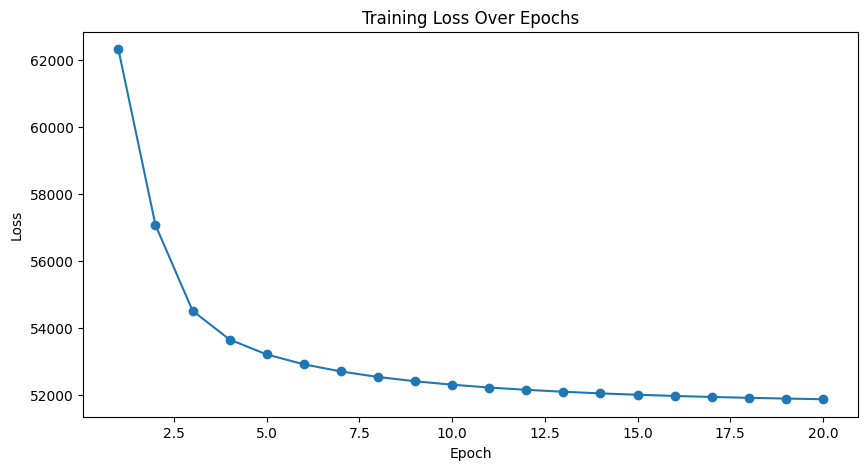

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'embeddings_trianing_loss.svg')
plt.show()

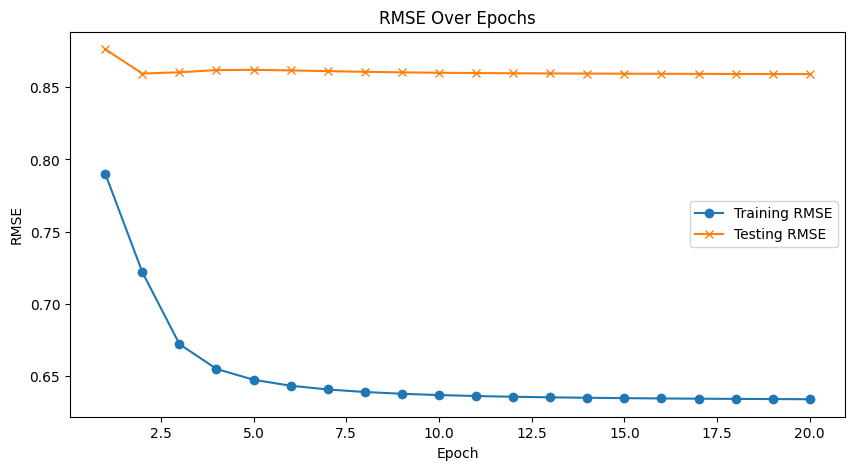

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'embeddings_rmse.svg')
plt.show()

In [29]:
import numpy as np
from numba import njit
import numpy as np

# --- Data Preprocessing ---
def preprocess_ratings(data, num_entities):
    all_x, all_y, all_r = [], [], []
    ptrs = [0]
    for i, ratings in enumerate(data):
        for j, r in ratings:
            all_x.append(i)
            all_y.append(j)
            all_r.append(r)
        ptrs.append(len(all_r))
    return (
        np.array(all_x, dtype=np.int32),
        np.array(all_y, dtype=np.int32),
        np.array(all_r, dtype=np.float64),
        np.array(ptrs, dtype=np.int32)
    )

# --- Numba-Accelerated Updates ---
@njit
def update_user_embeddings(num_users, user_ptrs, all_m, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           lam, gamma, tau_identity):
    dim = user_embeddings.shape[1]
    for u in range(num_users):
        start = user_ptrs[u]
        end = user_ptrs[u + 1]
        n = end - start
        if n == 0:
            continue
        movies = all_m[start:end]
        ratings = all_r[start:end]

        preds = np.zeros(n)
        item_vecs = np.zeros((n, dim))
        item_bias = np.zeros(n)
        for i in range(n):
            m = movies[i]
            vec = item_embeddings[m]
            item_vecs[i] = vec
            item_bias[i] = item_biases[m]
            preds[i] = np.dot(vec, user_embeddings[u]) + item_biases[m]

        residuals = ratings - preds
        user_bias = lam * np.sum(residuals) / (lam * n + gamma)
        user_biases[u] = user_bias

        adjusted = ratings - user_bias - item_bias
        A = lam * (item_vecs.T @ item_vecs) + tau_identity
        b = lam * (item_vecs.T @ adjusted)
        user_embeddings[u] = np.linalg.solve(A, b)

@njit
def update_item_embeddings(num_items, item_ptrs, all_u, all_r,
                           user_embeddings, item_embeddings,
                           user_biases, item_biases,
                           lam, gamma, tau_identity):
    dim = item_embeddings.shape[1]
    for m in range(num_items):
        start = item_ptrs[m]
        end = item_ptrs[m + 1]
        n = end - start
        if n == 0:
            continue
        users = all_u[start:end]
        ratings = all_r[start:end]

        preds = np.zeros(n)
        user_vecs = np.zeros((n, dim))
        user_bias = np.zeros(n)
        for i in range(n):
            u = users[i]
            vec = user_embeddings[u]
            user_vecs[i] = vec
            user_bias[i] = user_biases[u]
            preds[i] = np.dot(vec, item_embeddings[m]) + user_biases[u]

        residuals = ratings - preds
        item_bias = lam * np.sum(residuals) / (lam * n + gamma)
        item_biases[m] = item_bias

        adjusted = ratings - user_bias - item_bias
        A = lam * (user_vecs.T @ user_vecs) + tau_identity
        b = lam * (user_vecs.T @ adjusted)
        item_embeddings[m] = np.linalg.solve(A, b)

# --- Main Training Function ---
def training_optimised_vectorised_cuda(user_ratings_train, movie_ratings_train,
                                  user_ratings_test, movie_ratings_test,
                                  num_epochs=100, lam=0.1, gamma=0.1, tau=0.1,
                                  embeddings_dim=20, scale=1):
    num_users = len(user_ratings_train)
    num_items = len(movie_ratings_train)

    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim))
    user_biases = np.zeros(num_users)
    item_biases = np.zeros(num_items)

    tau_identity = np.ascontiguousarray(tau * np.eye(embeddings_dim))

    # Preprocess ratings
    all_u, all_m, all_r_u, user_ptrs = preprocess_ratings(user_ratings_train, num_users)
    all_m_rev, all_u_rev, all_r_m, item_ptrs = preprocess_ratings(movie_ratings_train, num_items)

    training_loss, training_RMSE, testing_RMSE = [], [], []

    for epoch in range(num_epochs):
        update_user_embeddings(num_users, user_ptrs, all_m, all_r_u,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               lam, gamma, tau_identity)

        update_item_embeddings(num_items, item_ptrs, all_u_rev, all_r_m,
                               user_embeddings, item_embeddings,
                               user_biases, item_biases,
                               lam, gamma, tau_identity)

        # Evaluation (same logic as before, unoptimized)
        train_preds, train_actuals = [], []
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])
            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            train_preds.extend(preds)
            train_actuals.extend(actual_ratings)

        train_preds = np.array(train_preds)
        train_actuals = np.array(train_actuals)
        train_error = np.sum((train_actuals - train_preds) ** 2)
        train_rmse = np.sqrt(train_error / len(train_actuals))

        train_loss = (lam * train_error) \
            + (gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))) \
            + (tau * (np.sum(user_embeddings ** 2) + np.sum(item_embeddings ** 2)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        # Test
        test_preds, test_actuals = [], []
        for u, ratings in enumerate(user_ratings_test):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])
            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            test_preds.extend(preds)
            test_actuals.extend(actual_ratings)

        test_preds = np.array(test_preds)
        test_actuals = np.array(test_actuals)
        test_error = np.sum((test_actuals - test_preds) ** 2)
        test_rmse = np.sqrt(test_error / len(test_actuals))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, [user_embeddings, item_embeddings], [user_biases, item_biases]


In [ ]:
def objective(trial):
    lam = trial.suggest_float('lam', 1e-1, 10.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-1, 10.0, log=True)
    tau = trial.suggest_float('tau', 1e-1, 10.0, log=True)
    embeddings_dim = trial.suggest_int('embeddings_dim', 10, 30)
    scale = trial.suggest_float('scale', 0.01, 1.0)

    num_epochs = 20
    
    training_loss, training_RMSE, testing_RMSE, _, _ = training_optimised_vectorised_cuda(user_ratings_train, movie_ratings_train,
    user_ratings_test, movie_ratings_test,
        num_epochs=num_epochs,
        lam=lam,
        gamma=gamma,
        tau=tau,
        embeddings_dim=embeddings_dim,
        scale=scale
    )

    return testing_RMSE[-1]

In [23]:
folder_name = external_data_path + "ml-32m"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

In [24]:
# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []


test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < train_ratio:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 61.216530323028564 seconds
Train Count: 25601640
Test Count: 6398564


In [25]:
best_params = {}
best_rmse = 0
if(optuna_optimisation):
    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=50)
    best_params = study.best_params
    best_rmse = study.best_value
    with open('best_hyperparams.txt', 'w') as f:
        for param, value in study.best_params.items():
            f.write(f"{param}: {value}\n")
        f.write(f"Best Test RMSE: {study.best_value}\n")

else:
    with open('best_hyperparams.txt', 'r') as f:
        for line in f:
            if ':' in line:
                key, value = line.strip().split(':')
                key = key.strip()
                value = value.strip()
                if key == 'Best Test RMSE':
                    best_rmse = float(value)
                else:
                    # Attempt to parse int, then float, else keep string
                    try:
                        value = int(value)
                    except ValueError:
                        try:
                            value = float(value)
                        except ValueError:
                            pass
                    best_params[key] = value

lam = best_params.get('lam')
gamma = best_params.get('gamma')
tau = best_params.get('tau')
embeddings_dim = best_params.get('embeddings_dim')
scale = best_params.get('scale')

print("Best Hyperparameters:", best_params)
print("Best Test RMSE:", best_rmse)

Best Hyperparameters: {'lam': 0.19516789886897798, 'gamma': 0.2598839921367706, 'tau': 2.95428675352858, 'embeddings_dim': 27, 'scale': 0.6737557519994634}
Best Test RMSE: 0.8530160249684084


In [58]:
# lam = best_params.get('lam')
# gamma = best_params.get('gamma')
# tau = best_params.get('tau')
# embeddings_dim = best_params.get('embeddings_dim')
# scale = best_params.get('scale')

lam = 0.5
gamma = 0.5
tau = 1
embeddings_dim = 20
scale = 0.4

In [27]:
def training_optimised_vectorised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    num_users = len(user_ratings_train)
    num_items = len(movie_ratings_train)
    
    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim))
    user_biases = np.zeros(num_users)
    item_biases = np.zeros(num_items)

    tau_identity = tau * np.eye(embeddings_dim)

    training_loss, training_RMSE, testing_RMSE = [], [], []

    for epoch in range(num_epochs):
        # USER UPDATE
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            item_vecs = item_embeddings[movies]
            item_bias = item_biases[movies]

            preds = (item_vecs @ user_embeddings[u]) + item_bias
            residuals = actual_ratings - preds

            user_biases[u] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_biases[u] - item_bias
            user_inverse_term = lam * (item_vecs.T @ item_vecs) + tau_identity
            user_term = lam * (item_vecs.T @ adjusted_residuals)

            user_embeddings[u] = np.linalg.solve(user_inverse_term, user_term)

        # ITEM UPDATE
        for m, ratings in enumerate(movie_ratings_train):
            users = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            user_vecs = user_embeddings[users]
            user_bias = user_biases[users]

            preds = (user_vecs @ item_embeddings[m]) + user_bias
            residuals = actual_ratings - preds

            item_biases[m] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_bias - item_biases[m]
            item_inverse_term = lam * (user_vecs.T @ user_vecs) + tau_identity
            item_term = lam * (user_vecs.T @ adjusted_residuals)

            item_embeddings[m] = np.linalg.solve(item_inverse_term, item_term)

        # --- Training RMSE ---
        train_preds, train_actuals = [], []
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            train_preds.append(preds)
            train_actuals.append(actual_ratings)

        train_preds = np.concatenate(train_preds)
        train_actuals = np.concatenate(train_actuals)

        train_error = np.sum((train_actuals - train_preds) ** 2)
        train_rmse = np.sqrt(train_error / len(train_actuals))

        train_loss = (lam * train_error) \
            + (gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))) \
            + (tau * (np.sum(user_embeddings ** 2) + np.sum(item_embeddings ** 2)))
        
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        # --- Testing RMSE ---
        test_preds, test_actuals = [], []
        for u, ratings in enumerate(user_ratings_test):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            test_preds.append(preds)
            test_actuals.append(actual_ratings)

        test_preds = np.concatenate(test_preds)
        test_actuals = np.concatenate(test_actuals)

        test_error = np.sum((test_actuals - test_preds) ** 2)
        test_rmse = np.sqrt(test_error / len(test_actuals))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, [user_embeddings, item_embeddings], [user_biases, item_biases] 


In [ ]:
num_epochs = 50
# embeddings_dim = 10
training_loss, training_RMSE, testing_RMSE, embeddings, biases = training_optimised_vectorised_cuda(user_ratings_train, movie_ratings_train,
    user_ratings_test, movie_ratings_test,
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/50, Loss: 9669288.3005, Train RMSE: 0.7906, Test RMSE: 0.9238
Epoch 2/50, Loss: 8377172.2143, Train RMSE: 0.7274, Test RMSE: 0.8743
Epoch 3/50, Loss: 7719313.2188, Train RMSE: 0.6944, Test RMSE: 0.8431
Epoch 4/50, Loss: 7361260.5351, Train RMSE: 0.6766, Test RMSE: 0.8257
Epoch 5/50, Loss: 7149167.8651, Train RMSE: 0.6665, Test RMSE: 0.8160
Epoch 6/50, Loss: 7010890.9396, Train RMSE: 0.6603, Test RMSE: 0.8105


In [43]:
save_dir = os.path.join("..", "models")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "recommender_model_params.npz")

np.savez_compressed(
    save_path,
    user_embeddings=embeddings[0],
    item_embeddings=embeddings[1],
    user_biases=biases[0],
    item_biases=biases[1]
)


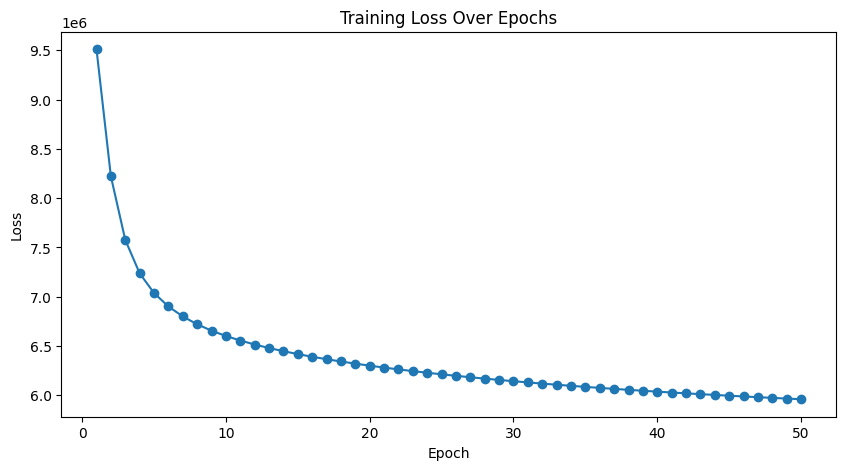

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'large_embeddings_trianing_loss.svg')
plt.show()

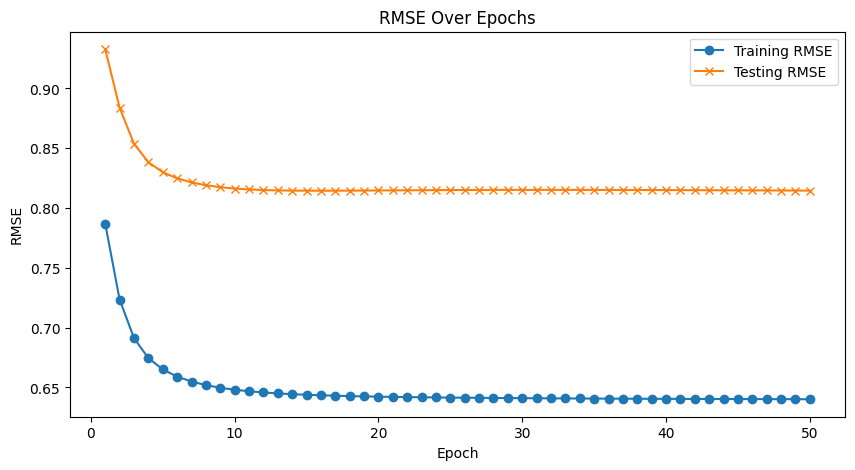

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'large_embeddings_rmse.svg')
plt.show()

In [46]:
save_dir = os.path.join("..", "models")
save_path = os.path.join(save_dir, "recommender_model_params.npz")

# Load the model parameters
with np.load(save_path, allow_pickle=True) as data:
    user_embeddings = data['user_embeddings']
    item_embeddings = data['item_embeddings']
    user_biases = data['user_biases']
    item_biases = data['item_biases']

print("User Embeddings Shape:", user_embeddings.shape)
print("Item Embeddings Shape:", item_embeddings.shape)
print("User Biases Shape:", user_biases.shape)
print("Item Biases Shape:", item_biases.shape)

User Embeddings Shape: (200948, 20)
Item Embeddings Shape: (84432, 20)
User Biases Shape: (200948,)
Item Biases Shape: (84432,)


In [52]:
user_id = "dummy_user"
movie_id = "3114"
rating = 5

user_idx = len(user_to_idx)
user_to_idx[user_id] = user_idx
idx_to_user[user_idx] = user_id
movie = movie_to_idx[movie_id]

In [48]:
folder_name = external_data_path + "ml-32m"
file_name = "movies.csv" 
file_path = os.path.join(folder_name, file_name)

movie_id_to_movie_name = {}
movie_name_to_movie_id = {}

try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            movie_id = row[0]
            movie_name = row[1]

            if movie_id not in movie_id_to_movie_name:
                movie_id_to_movie_name[movie_id] = movie_name
                movie_name_to_movie_id[movie_name] = movie_id

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [53]:
num_epochs = 100
# embeddings_dim = 10

dummy_user_embedding = np.random.normal(0, scale, embeddings_dim)
dummy_user_bias = 0
movie_embedding = item_embeddings[movie]
movie_bias = item_biases[movie]

tau_identity = tau * np.eye(embeddings_dim)

training_loss, training_RMSE, testing_RMSE = [], [], []

for epoch in range(num_epochs):
    actual_rating = rating
    pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias + movie_bias
    residual = actual_rating - pred

    dummy_user_bias = lam * residual / ((lam * 1) + gamma)

    adjusted_residual = actual_rating - dummy_user_bias - movie_bias
    user_inverse_term = lam * np.outer(movie_embedding, movie_embedding) + tau_identity
    user_term = lam * (movie_embedding * adjusted_residual)

    dummy_user_embedding = np.linalg.solve(user_inverse_term, user_term)

    # pred = (dummy_user_embedding @ movie_embedding) + dummy_user_bias
    # residuals = actual_rating - pred

    # item_biases[movie] = lam * residual / ((lam * 1) + gamma)

    # adjusted_residual = actual_rating - dummy_user_bias - item_biases[movie]
    # item_inverse_term = lam * np.outer(dummy_user_embedding, dummy_user_embedding) + tau_identity
    # item_term = lam * (dummy_user_embedding * adjusted_residual)

    # item_embeddings[movie] = np.linalg.solve(item_inverse_term, item_term)

    pred = (dummy_user_embedding @ item_embeddings[movie]) + dummy_user_bias + item_biases[movie]
    train_error = actual_rating - pred
    train_loss = (lam * train_error) \
        + (gamma * (np.sum(dummy_user_bias ** 2) + np.sum(item_biases[movie] ** 2))) \
        + (tau * (np.sum(dummy_user_embedding ** 2) + np.sum(item_embeddings[movie] ** 2)))


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Epoch 1/100, Loss: 9.6828
Epoch 2/100, Loss: 7.6464
Epoch 3/100, Loss: 7.6312
Epoch 4/100, Loss: 7.6316
Epoch 5/100, Loss: 7.6316
Epoch 6/100, Loss: 7.6316
Epoch 7/100, Loss: 7.6316
Epoch 8/100, Loss: 7.6316
Epoch 9/100, Loss: 7.6316
Epoch 10/100, Loss: 7.6316
Epoch 11/100, Loss: 7.6316
Epoch 12/100, Loss: 7.6316
Epoch 13/100, Loss: 7.6316
Epoch 14/100, Loss: 7.6316
Epoch 15/100, Loss: 7.6316
Epoch 16/100, Loss: 7.6316
Epoch 17/100, Loss: 7.6316
Epoch 18/100, Loss: 7.6316
Epoch 19/100, Loss: 7.6316
Epoch 20/100, Loss: 7.6316
Epoch 21/100, Loss: 7.6316
Epoch 22/100, Loss: 7.6316
Epoch 23/100, Loss: 7.6316
Epoch 24/100, Loss: 7.6316
Epoch 25/100, Loss: 7.6316
Epoch 26/100, Loss: 7.6316
Epoch 27/100, Loss: 7.6316
Epoch 28/100, Loss: 7.6316
Epoch 29/100, Loss: 7.6316
Epoch 30/100, Loss: 7.6316
Epoch 31/100, Loss: 7.6316
Epoch 32/100, Loss: 7.6316
Epoch 33/100, Loss: 7.6316
Epoch 34/100, Loss: 7.6316
Epoch 35/100, Loss: 7.6316
Epoch 36/100, Loss: 7.6316
Epoch 37/100, Loss: 7.6316
Epoch 38/1

In [54]:
from collections import defaultdict

folder_name = external_data_path + "ml-32m"
file_name = "ratings.csv"
file_path = os.path.join(folder_name, file_name)

movie_rating_counts = defaultdict(int)

with open(file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # skip header
    for user_id, movie_id, rating, timestamp in reader:
        movie_rating_counts[movie_id] += 1

popular_movies = [movie_id for movie_id, count in movie_rating_counts.items() if count > 10]

In [57]:
print(dummy_user_embedding)
print(item_embeddings[movie])
print(dummy_user_bias)
print(item_biases[movie])
print(movie_id_to_movie_name[idx_to_movie[movie]])
# actual_ratings = []
# for u, ratings in enumerate(user_ratings_train):
#     actual_ratings.append(r for _, r in ratings)

# Predict ratings for all movies for the dummy user
mapped_indices = [movie_to_idx[mid] for mid in popular_movies]
predicted_ratings = dummy_user_embedding @ item_embeddings[mapped_indices].T

top_N = 10  # or however many you want to see
top_movie_indices = np.argsort(predicted_ratings)[::-1][:top_N]

# If you have a mapping from movie indices to titles
for idx in top_movie_indices:
    print(f"Movie: {movie_id_to_movie_name[idx_to_movie[idx]]}, Predicted Rating: {predicted_ratings[idx]:.2f}")

[ 0.09441528  0.12345907  0.08291304  0.34446901  0.4049587   0.19709913
 -0.05057794 -0.08965153  0.43975364 -0.13707793  0.31892851  0.03761895
 -0.22904058 -0.04873306 -0.07771007 -0.14417268  0.18940151  0.07906224
  0.47991559  0.40637978]
[ 0.3164612   0.4138102   0.27790797  1.15459144  1.35734084  0.66063698
 -0.16952716 -0.30049406  1.47396653 -0.4594579   1.0689848   0.12609123
 -0.76769836 -0.16334351 -0.26046867 -0.48323809  0.63483611  0.26500086
  1.60858139  1.36210401]
0.14917354822166207
0.5381095695653215
Toy Story 2 (1999)
Movie: Princess Mononoke (Mononoke-hime) (1997), Predicted Rating: 4.01
Movie: Babe (1995), Predicted Rating: 3.83
Movie: Toy Story (1995), Predicted Rating: 3.70
Movie: Blazing Saddles (1974), Predicted Rating: 3.69
Movie: Jonah Hex (2010), Predicted Rating: 3.58
Movie: Muppet Christmas Carol, The (1992), Predicted Rating: 3.45
Movie: Charlotte's Web (1973), Predicted Rating: 3.36
Movie: Multiplicity (1996), Predicted Rating: 3.32
Movie: Monsters,